#Introduction

In this notebook we will explore time series forecasting with sea surface temperatures. Global sea surface temperatures have been gradually rising throughout the world for a while now, as will be shown in the notebook. Using data from approximately the last 80 years or so, we will use time series forecasting techniques to predict how the sea surface temperature will increase in the coming years.

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.signal import welch

from scipy.ndimage import uniform_filter1d
from scipy.ndimage import median_filter

# Load and Clean Data

In [80]:
dfnp = pd.read_csv("https://github.com/galenegan/DATA-3320/raw/main/climate/north_pacific.csv")
dfsp = pd.read_csv("https://github.com/galenegan/DATA-3320/raw/main/climate/south_pacific.csv")

We now have the data for the north pacific and south pacific sea surface temperatures

In [81]:
df = dfnp.merge(dfsp, on = 'time', how = 'left')

We will use the difference between the north and south pacific to predict el nino/ la nina cycles. Since during el nino, the south pacific is typically warmer than the north pacific, we can use this difference to predict how the sea surface temperature changes.

In [82]:
df.head()

,sst_x,u10_x,hsig_x,time,latitude_x,longitude_x,sst_y,u10_y,hsig_y,latitude_y,longitude_y
0,286.97070,0.612978,4.136298,1940-01-01 12:00:00,34.9,-165.0,291.74900,1.479218,2.039036,-35.0,-165.0
1,286.97836,2.574189,2.759662,1940-01-02 12:00:00,34.9,-165.0,291.80466,0.636111,1.567293,-35.0,-165.0
2,287.01630,2.623150,1.873087,1940-01-03 12:00:00,34.9,-165.0,291.85544,3.894659,1.214057,-35.0,-165.0
3,287.02680,-1.868878,1.753748,1940-01-04 12:00:00,34.9,-165.0,291.90817,3.991070,2.437233,-35.0,-165.0
4,287.03183,3.412738,2.692871,1940-01-05 12:00:00,34.9,-165.0,291.95996,2.706026,2.678540,-35.0,-165.0


In [83]:
pd.to_datetime(df['time'])

0       1940-01-01 12:00:00
1       1940-01-02 12:00:00
2       1940-01-03 12:00:00
3       1940-01-04 12:00:00
4       1940-01-05 12:00:00
                ...        
30736   2024-02-25 12:00:00
30737   2024-02-26 12:00:00
30738   2024-02-27 12:00:00
30739   2024-02-28 12:00:00
30740   2024-02-29 12:00:00
Name: time, Length: 30741, dtype: datetime64[ns]

In [84]:
df['diffsst'] = df['sst_x'] - df['sst_y']

In [85]:
df = df[['sst_x','sst_y','diffsst', 'time', 'u10_x','u10_y']]

In [86]:
df = df.rename(columns = {"sst_y":"south_pacific_sst",
                          "sst_x":"north_pacific_sst",
                          'u10_x':"north_pacific_wind",
                          "u10_y":"south_pacific_wind"})

We will add a moving average for all of the sst data

In [87]:
ssst = df['south_pacific_sst']
window_len = 365 # One year moving average
south_pacific_sstma = uniform_filter1d(ssst, size=window_len)

df['ssst_ma'] = south_pacific_sstma

In [88]:
nsst = df['north_pacific_sst']
nsst_ma = uniform_filter1d(nsst, size=window_len)

df['nsst_ma'] = nsst_ma

In [89]:
dsst = df['diffsst']
dsst_ma = uniform_filter1d(nsst, size=window_len)

df['dsst_ma'] = dsst_ma

In [90]:
spw = df['south_pacific_wind']
spwma = uniform_filter1d(spw, size=(window_len))

df['spwma'] = spwma

In [91]:
npw = df['north_pacific_wind']
npwma = uniform_filter1d(npw, size=(window_len))

df['npwma'] = npwma

In [92]:
df.describe()

,north_pacific_sst,south_pacific_sst,diffsst,north_pacific_wind,south_pacific_wind,ssst_ma,nsst_ma,dsst_ma,spwma,npwma
count,30741.000000,30741.000000,30741.000000,30741.000000,30741.000000,30741.000000,30741.000000,30741.000000,30741.000000,30741.000000
mean,291.723484,290.573772,1.149712,1.462743,0.771190,290.573772,291.723484,291.723484,0.771190,1.462743
std,3.825816,2.337555,5.975451,6.038611,6.082505,0.535967,0.660909,0.660909,0.816063,0.915996
min,284.794000,285.857940,-10.530030,-18.708815,-18.759240,289.351935,287.167071,287.167071,-1.448277,-0.910827
25%,288.351680,288.417330,-4.454010,-3.112220,-3.833070,290.186728,291.286915,291.286915,0.210874,0.797538
50%,290.842040,290.473970,0.336030,1.232235,0.715698,290.498820,291.727993,291.727993,0.794708,1.394213
75%,295.407650,292.647000,7.023400,5.660821,5.290995,290.868475,292.156898,292.156898,1.272048,2.082794
max,300.266850,298.204830,13.120230,24.724703,20.636452,292.067953,293.454082,293.454082,3.566326,4.865099


In [93]:
df.head()

,north_pacific_sst,south_pacific_sst,diffsst,time,north_pacific_wind,south_pacific_wind,ssst_ma,nsst_ma,dsst_ma,spwma,npwma
0,286.97070,291.74900,-4.77830,1940-01-01 12:00:00,0.612978,1.479218,291.794269,287.167071,287.167071,1.471448,4.825006
1,286.97836,291.80466,-4.82630,1940-01-02 12:00:00,2.574189,0.636111,291.794317,287.168284,287.168284,1.477486,4.825809
2,287.01630,291.85544,-4.83914,1940-01-03 12:00:00,2.623150,3.894659,291.794411,287.170701,287.170701,1.487488,4.834326
3,287.02680,291.90817,-4.88137,1940-01-04 12:00:00,-1.868878,3.991070,291.794546,287.174310,287.174310,1.483868,4.841787
4,287.03183,291.95996,-4.92813,1940-01-05 12:00:00,3.412738,2.706026,291.794720,287.179093,287.179093,1.478885,4.851519


#The Questions:

How can we use our data to see how the sea surface temperature is increasing over time?

Can we use the data to predict el nino/ la nina climate cycles?

# Moving averages

To get a general overview of the data, we will plot the daily signal and the yearly moving average for the data to get a more clear idea of how the sea surface temperature is increasing.

In [94]:
t = np.arange(len(df))

30741


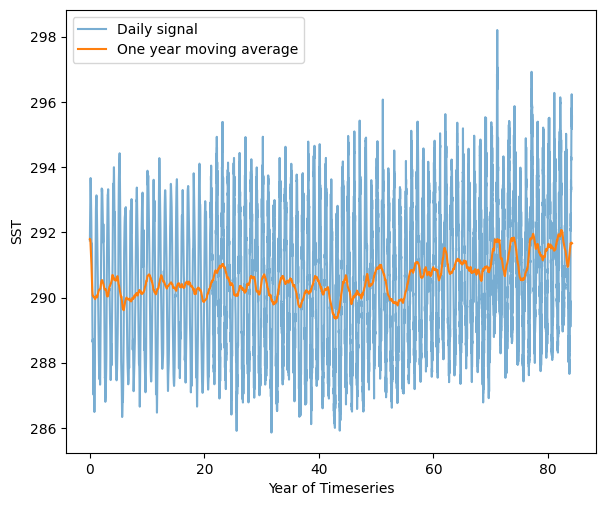

In [95]:
south_pacific_sst = df['south_pacific_sst']

window_len = 365 # One year moving average
sst_ma = uniform_filter1d(south_pacific_sst, size=window_len)
print(len(sst_ma))


fig, ax = plt.subplots()
ax.plot(t / 365, south_pacific_sst, alpha=0.6, label="Daily signal")
ax.plot(t / 365, sst_ma, label="One year moving average")
ax.set_xlabel("Year of Timeseries")
ax.set_ylabel("SST")
ax.legend()
fig.set_size_inches(6, 5)
fig.tight_layout(pad=0.5)

As we can see, the moving average removes the noise that is going on with the sea surface temperatures daily, since that varies a lot more than what is going on yearly.

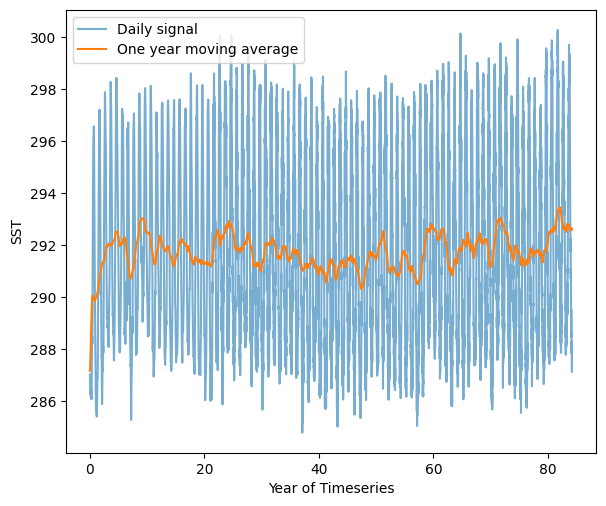

In [96]:
north_pacific_sst = df['north_pacific_sst']

window_len = 365 # One year moving average
sst_ma = uniform_filter1d(north_pacific_sst, size=window_len)

fig, ax = plt.subplots()
ax.plot(t / 365, north_pacific_sst, alpha=0.6, label="Daily signal")
ax.plot(t / 365, sst_ma, label="One year moving average")
ax.set_xlabel("Year of Timeseries")
ax.set_ylabel("SST")
ax.legend()
fig.set_size_inches(6, 5)
fig.tight_layout(pad=0.5)

#Wind speed moving average

We will now look at the wind speed, however for this we use a

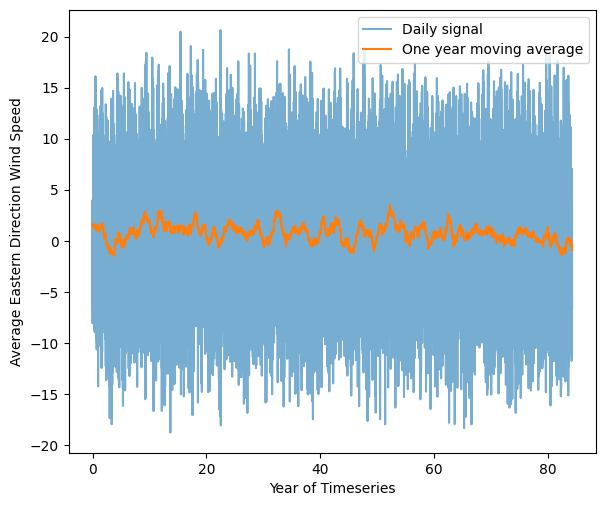

In [97]:
south_pacific_wind = df['south_pacific_wind']

fig, ax = plt.subplots()
ax.plot(t / 365, south_pacific_wind, alpha=0.6, label="Daily signal")
ax.plot(t / 365, spwma, label="One year moving average")
ax.set_xlabel("Year of Timeseries")
ax.set_ylabel("Average Eastern Direction Wind Speed")
ax.legend()
fig.set_size_inches(6, 5)
fig.tight_layout(pad=0.5)

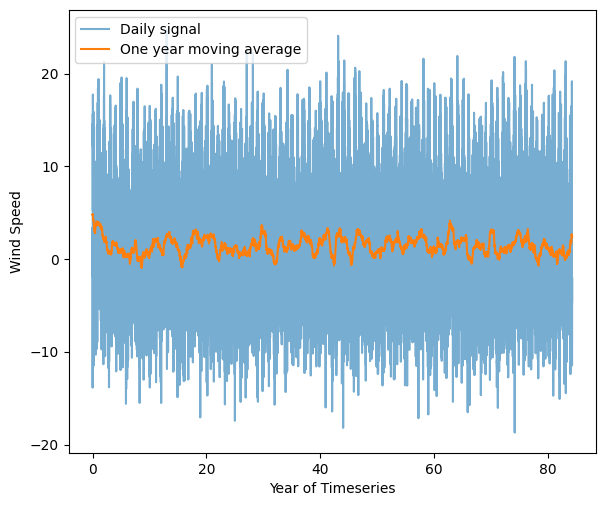

In [98]:
north_pacific_wind = df['north_pacific_wind']

fig, ax = plt.subplots()
ax.plot(t / 365, north_pacific_wind, alpha=0.6, label="Daily signal")
ax.plot(t / 365, npwma, label="One year moving average")
ax.set_xlabel("Year of Timeseries")
ax.set_ylabel("Wind Speed")
ax.legend()
fig.set_size_inches(6, 5)
fig.tight_layout(pad=0.5)

In [99]:
ssst = df['south_pacific_sst']
n = len(df)
t = np.arange(n)  # Daily data, so the time vector starts at 0 and ends at n - 1
dt = t[1] - t[0]  # Sampling interval dt = 1 day
fs = 1 / dt  # Sampling frequency fs = 1 sample/day (often abbreviated cpd for cycles per day)
f0 = (1 / n) / dt  # Frequency resolution
p = int((n - 1) / 2)
print(p)

15370


#Spectral analysis

We will now use spectral analysis to verify our assumptions that our data is periodic across a year.

In [100]:
a = np.zeros((p + 1,))
b = np.zeros((p + 1,))
frequency = np.zeros((p + 1,))

for idx, j in enumerate(range(p + 1)):
    a[j] = (2 / n) * np.sum(ssst * np.cos(2 * np.pi * f0 * j * t))
    b[j] = (2 / n) * np.sum(ssst * np.sin(2 * np.pi * f0 * j * t))
    frequency[idx] = f0 * j
a[0] = a[0] / 2

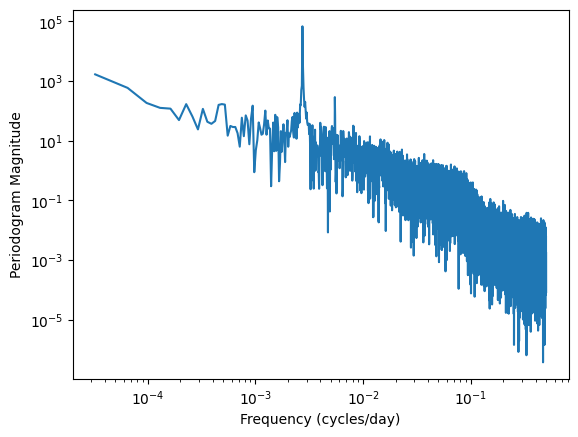

In [101]:
dft_sst = np.fft.fft(df["south_pacific_sst"].values)[:p + 1]
P_from_dft_sst = (np.real(dft_sst)**2 + np.imag(dft_sst)**2) / n

fig, ax = plt.subplots()
ax.plot(frequency[1:], P_from_dft_sst[1:])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("Periodogram Magnitude")
plt.show()

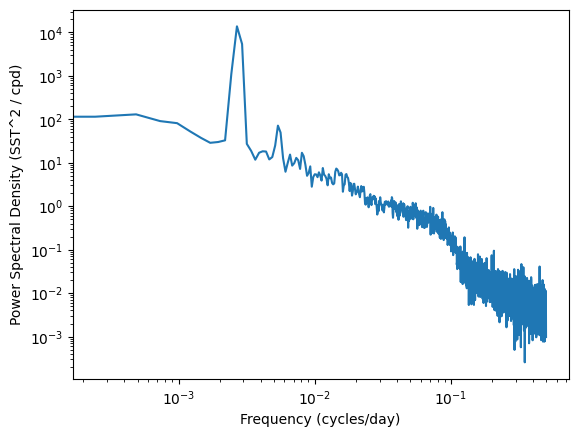

In [102]:
f, Pw = welch(ssst, fs=1.0, window="hamming", nperseg=4096)
fig, ax = plt.subplots()
ax.plot(f, Pw)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("Power Spectral Density (SST^2 / cpd)")
plt.show()

We have a frequency between 1/1000 and 1/100, which is somewhere in the range of where a year should be which makes sense with how the seasons work.

In [103]:
spw = df['south_pacific_wind']
n = len(df)
t = np.arange(n)  # Daily data, so the time vector starts at 0 and ends at n - 1
dt = t[1] - t[0]  # Sampling interval dt = 1 day
fs = 1 / dt  # Sampling frequency fs = 1 sample/day (often abbreviated cpd for cycles per day)
f0 = (1 / n) / dt  # Frequency resolution
p = int((n - 1) / 2)
print(p)

15370


In [104]:
for idx, j in enumerate(range(p + 1)):
    a[j] = (2 / n) * np.sum(spw * np.cos(2 * np.pi * f0 * j * t))
    b[j] = (2 / n) * np.sum(spw * np.sin(2 * np.pi * f0 * j * t))
    frequency[idx] = f0 * j
a[0] = a[0] / 2

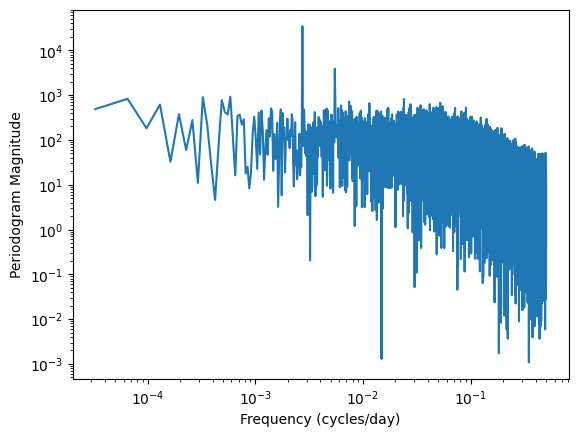

In [105]:
dft_wind = np.fft.fft(df["south_pacific_wind"].values)[:p + 1]
P_from_dft_wind = (np.real(dft_wind)**2 + np.imag(dft_wind)**2) / n

fig, ax = plt.subplots()
ax.plot(frequency[1:], P_from_dft_wind[1:])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("Periodogram Magnitude")
plt.show()

Here we can guess we have cycles of about once a year, and once every half year, but it is hard to see on this bound.

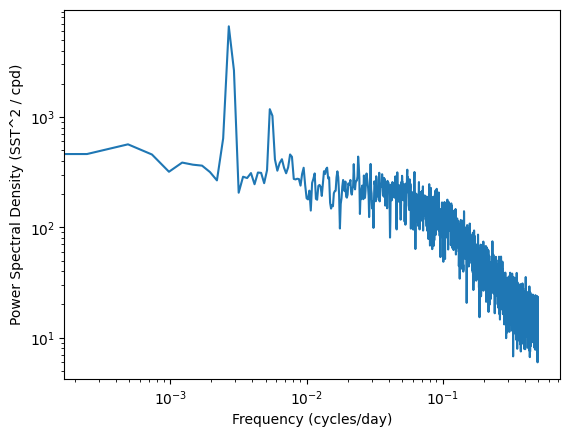

In [106]:
spw = df['south_pacific_wind']
f, Pw = welch(spw, fs=1.0, window="hamming", nperseg=4096)
fig, ax = plt.subplots()
ax.plot(f, Pw)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("Power Spectral Density (SST^2 / cpd)")
plt.show()

In [107]:
P = (n / 4) * (a**2 + b**2)

np.argmax(P[1:])

1 / frequency[1:][np.argmax(P[1:])]

365.9642857142858

In [108]:
ssst = df["south_pacific_sst"].values.reshape(-1,1)
nsst = df["north_pacific_sst"].values.reshape(-1,1)
time = np.arange(len(df))

In [109]:
df.head()

,north_pacific_sst,south_pacific_sst,diffsst,time,north_pacific_wind,south_pacific_wind,ssst_ma,nsst_ma,dsst_ma,spwma,npwma
0,286.97070,291.74900,-4.77830,1940-01-01 12:00:00,0.612978,1.479218,291.794269,287.167071,287.167071,1.471448,4.825006
1,286.97836,291.80466,-4.82630,1940-01-02 12:00:00,2.574189,0.636111,291.794317,287.168284,287.168284,1.477486,4.825809
2,287.01630,291.85544,-4.83914,1940-01-03 12:00:00,2.623150,3.894659,291.794411,287.170701,287.170701,1.487488,4.834326
3,287.02680,291.90817,-4.88137,1940-01-04 12:00:00,-1.868878,3.991070,291.794546,287.174310,287.174310,1.483868,4.841787
4,287.03183,291.95996,-4.92813,1940-01-05 12:00:00,3.412738,2.706026,291.794720,287.179093,287.179093,1.478885,4.851519


#Autoregression

In [110]:
k = len(df) // 8

# Let's do a train test split
train_indices = list(range(3*len(df) // 4))
test_indices = list(range(3 * len(df)  // 4, len(df)))
type(train_indices)

nsst_train = nsst[train_indices, :]
nsst_test = nsst[test_indices, :]
ssst_train = ssst[train_indices, :]
ssst_test = ssst[test_indices, :]


nsst_lagged_train = nsst_train[:-k, :]
nsst_lagged_test = nsst_test[:-k, :]
ssst_lagged_train = ssst_train[k:, :]
ssst_lagged_test = ssst_test[k:, :]


reg = LinearRegression().fit(nsst_lagged_train, ssst_lagged_train)
sst_predicted = reg.predict(ssst_lagged_test)
mae = np.nanmean(np.abs(sst_predicted - nsst_lagged_test))

Here we will use standard regression on the last 25% of our data to get our model.

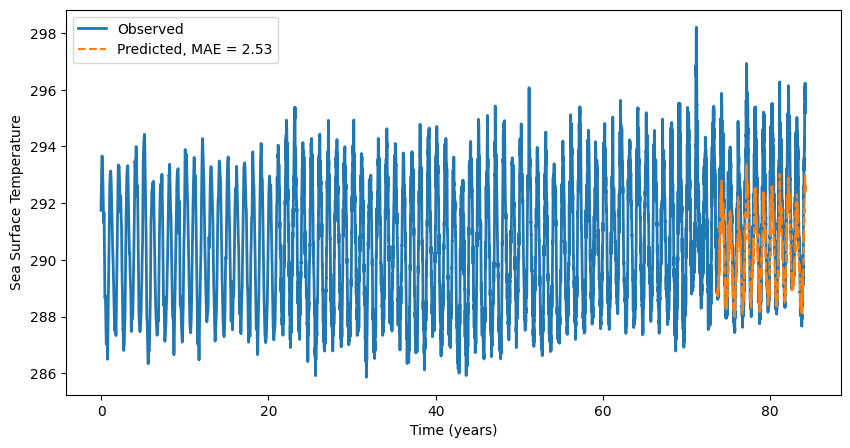

In [111]:
fig, ax = plt.subplots()
ax.plot(time / 365, ssst, '-', linewidth=2, label="Observed")
ax.plot(time[test_indices[k:]] / 365, sst_predicted, '--', label=f"Predicted, MAE = {mae:.2f}")
ax.legend()
ax.set_xlabel("Time (years)")
ax.set_ylabel("Sea Surface Temperature")
fig.set_size_inches(10, 5)
#fig.tight_layout(pad=0.5)
plt.show()

This, however doesn't tell us much for predicting future data, so we will do this based on the yearly average

#Moving average time series

Since the daily data doesn't really tell us much, we will use the moving average for all of the data

In [157]:
south_pacific_sstma = df["ssst_ma"].values.reshape(-1,1)
north_pacific_sstma = df["nsst_ma"].values.reshape(-1,1)
time = np.arange(len(df))

In [158]:
k = len(df) // 8

# Let's do a train test split
train_indices = list(range(3*len(df) // 4))
test_indices = list(range(3 * len(df)  // 4, len(df)))
type(train_indices)

nsstma_train = north_pacific_sstma[train_indices, :]
nsstma_test = north_pacific_sstma[test_indices, :]
ssstma_train = south_pacific_sstma[train_indices, :]
ssstma_test = south_pacific_sstma[test_indices, :]


nsstma_lagged_train = nsstma_train[:-k, :]
nsstma_lagged_test = nsstma_test[:-k, :]
ssstma_lagged_train = ssstma_train[k:, :]
ssstma_lagged_test = ssstma_test[k:, :]


reg = LinearRegression().fit(nsstma_lagged_train, ssstma_lagged_train)
sstma_predicted = reg.predict(ssstma_lagged_test)
mae = np.nanmean(np.abs(sstma_predicted - nsstma_lagged_test))

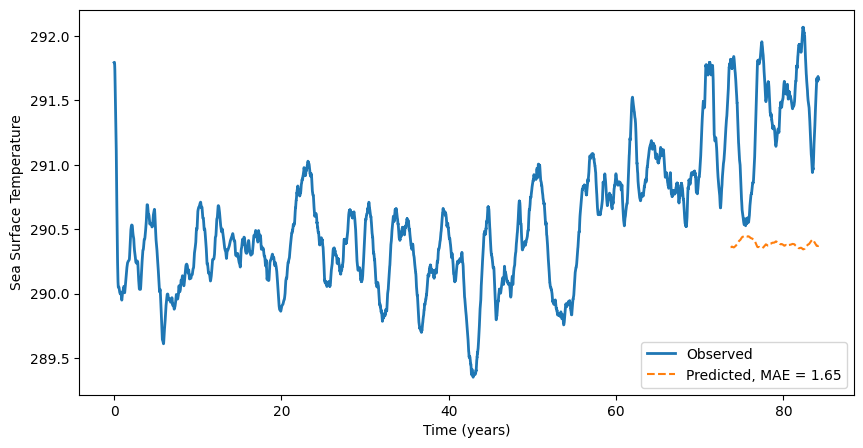

In [159]:
fig, ax = plt.subplots()
ax.plot(time / 365, south_pacific_sstma, '-', linewidth=2, label="Observed")
ax.plot(time[test_indices[k:]] / 365, sstma_predicted, '--', label=f"Predicted, MAE = {mae:.2f}")
ax.legend()
ax.set_xlabel("Time (years)")
ax.set_ylabel("Sea Surface Temperature")
fig.set_size_inches(10, 5)
#fig.tight_layout(pad=0.5)
plt.show()

From this model we get a pretty bad read at how the sea surface temperature is increasing. What if, instead we use data from the past 60 years?

In [143]:
years = 365 * 60 + 30

last_60_yrs = df[-years:]
last_60_yrs = last_60_yrs.reset_index()
time_last60 = np.arange(len(last_60_yrs))
south_pacific_sstma_last60 = last_60_yrs["ssst_ma"].values.reshape(-1,1)
north_pacific_sstma_last60 = last_60_yrs["nsst_ma"].values.reshape(-1,1)

last_60_yrs.head()

,index,north_pacific_sst,south_pacific_sst,diffsst,time,north_pacific_wind,south_pacific_wind,ssst_ma,nsst_ma,dsst_ma,spwma,npwma
0,8811,288.59323,293.93427,-5.34104,1964-02-15 12:00:00,1.234994,-4.909762,290.619050,292.757261,292.757261,1.683674,1.142748
1,8812,288.51640,293.79860,-5.28220,1964-02-16 12:00:00,7.690302,-4.680059,290.618447,292.760738,292.760738,1.684051,1.153489
2,8813,288.40778,293.67407,-5.26629,1964-02-17 12:00:00,1.206720,-9.829937,290.618250,292.763444,292.763444,1.687554,1.154354
3,8814,288.27936,293.61237,-5.33301,1964-02-18 12:00:00,12.888477,-4.912997,290.618538,292.765371,292.765371,1.675916,1.149470
4,8815,288.15717,293.62033,-5.46316,1964-02-19 12:00:00,4.579535,-6.267921,290.619186,292.766594,292.766594,1.703507,1.151845


Now that we have the data from the last 60 years, we will do the same process on this.

In [144]:
k = len(last_60_yrs)//8

# Let's do a train test split
train_indices = list(range(3*len(last_60_yrs) // 4))
test_indices = list(range(3 * len(last_60_yrs)  // 4, len(last_60_yrs)))
type(train_indices)

nsstma_train_last60 = north_pacific_sstma_last60[train_indices, :]
nsstma_test_last60 = north_pacific_sstma_last60[test_indices, :]
ssstma_train_last60 = south_pacific_sstma_last60[train_indices, :]
ssstma_test_last60 = south_pacific_sstma_last60[test_indices, :]


nsstma_lagged_train_last60 = nsstma_train_last60[:-k, :]
nsstma_lagged_test_last60 = nsstma_test_last60[:-k, :]
ssstma_lagged_train_last60 = ssstma_train_last60[k:, :]
ssstma_lagged_test_last60 = ssstma_test_last60[k:, :]

reg = LinearRegression().fit(nsstma_lagged_train_last60, ssstma_lagged_train_last60)
sstma_predicted_last60 = reg.predict(ssstma_lagged_test_last60)
mae = np.nanmean(np.abs(sstma_predicted_last60 - nsstma_lagged_test_last60))

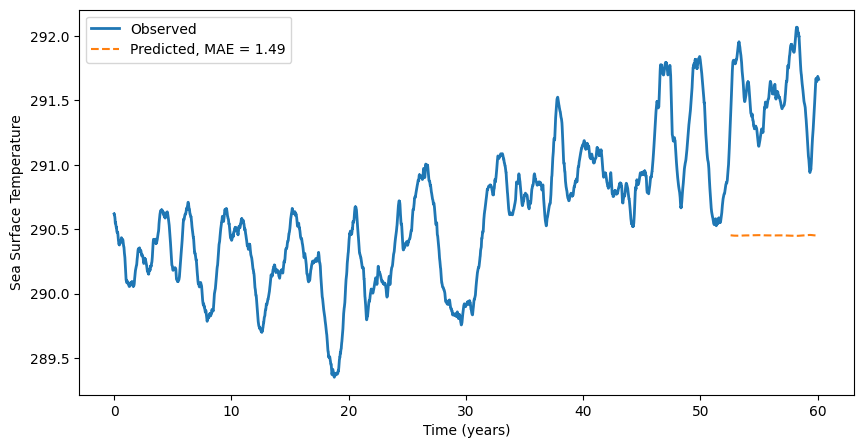

In [145]:
fig, ax = plt.subplots()
ax.plot(time_last60 / 365, south_pacific_sstma_last60, '-', linewidth=2, label="Observed")
ax.plot(time_last60[test_indices[k:]] / 365, sstma_predicted, '--', label=f"Predicted, MAE = {mae:.2f}")
ax.legend()
ax.set_xlabel("Time (years)")
ax.set_ylabel("Sea Surface Temperature")
fig.set_size_inches(10, 5)
#fig.tight_layout(pad=0.5)
plt.show()

This, however still gives us a pretty bad idea about what's going on

#Wind Speed Regression

In [146]:
npwma_last60 = last_60_yrs["npwma"].values.reshape(-1,1)
spwma_last60 = last_60_yrs["spwma"].values.reshape(-1,1)


In [147]:
k = 365 * 5

# Let's do a train test split
train_indices = list(range(2 * len(last_60_yrs) // 3))
test_indices = list(range(2 * len(last_60_yrs)  // 3, len(last_60_yrs)))
type(train_indices)

npwma_train_last60 = npwma_last60[train_indices, :]
npwma_test_last60 = npwma_last60[test_indices, :]
spwma_train_last60 = spwma_last60[train_indices, :]
spwma_test_last60 = spwma_last60[test_indices, :]


npwma_lagged_train_last60 = npwma_train_last60[:-k, :]
npwma_lagged_test_last60 = npwma_test_last60[:-k, :]
spwma_lagged_train_last60 = spwma_train_last60[k:, :]
spwma_lagged_test_last60 = spwma_test_last60[k:, :]
#nsstma_lagged_train = nsstma_train[:-k, :]
#nsstma_lagged_test = nsstma_test[:-k, :]
#ssstma_lagged_train = ssstma_train[k:, :]
#ssstma_lagged_test = ssstma_test[k:, :]

reg = LinearRegression().fit(npwma_lagged_train_last60, spwma_lagged_train_last60)
wind_predicted_last60 = reg.predict(spwma_lagged_test_last60)
mae = np.nanmean(np.abs(wind_predicted_last60 - npwma_lagged_test_last60))

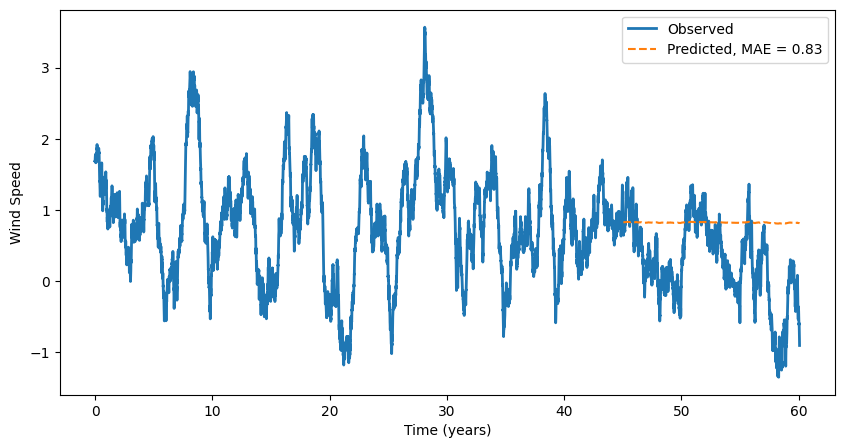

In [148]:
fig, ax = plt.subplots()
ax.plot(time_last60 / 365, spwma_last60, '-', linewidth=2, label="Observed")
ax.plot(time_last60[test_indices[k:]] / 365, wind_predicted_last60, '--', label=f"Predicted, MAE = {mae:.2f}")
ax.legend()
ax.set_xlabel("Time (years)")
ax.set_ylabel("Wind Speed")
fig.set_size_inches(10, 5)
#fig.tight_layout(pad=0.5)
plt.show()

#Prophet Model

Since our models were very hard to get a good read for anytihng, really, we will switch to a different model and use Fourier techniques to plot the seasonality in the data

In [121]:
!pip install prophet

In [149]:
time = np.arange(len(df))
nsst_ma20 = df["nsst_ma"].values.reshape(-1,1)

In [150]:
from prophet import Prophet

# We use an 80/20 split
train_indices = list(range(len(df) * 4 // 5))
test_indices = list(range(len(df) * 4 // 5, len(df)))

nsst_train = nsst_ma20[train_indices, :]
nsst_test = nsst_ma20[test_indices, :]

df_train = pd.DataFrame({"ds": df.loc[train_indices, 'time'], "y": nsst_train.squeeze()})

In [151]:
# Fitting the model
m1 = Prophet()
m1.add_seasonality(name = "2yr", period = 365 * 2, fourier_order = 10)
m1.add_seasonality(name = "5yr", period = 365 * 5, fourier_order = 10)
m1.add_seasonality(name = "10yr", period = 365 * 10, fourier_order = 10)
#m.add_seasonality(name = "17yr", period = 365 * 17, fourier_order = 10)

m1.fit(df_train)
future1 = m1.make_future_dataframe(periods=len(nsst_test), freq="D")
forecast1 = m1.predict(future1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsadmoo6r/zyakmkl4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsadmoo6r/p55mmrxs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92020', 'data', 'file=/tmp/tmpsadmoo6r/zyakmkl4.json', 'init=/tmp/tmpsadmoo6r/p55mmrxs.json', 'output', 'file=/tmp/tmpsadmoo6r/prophet_model_im7jflp/prophet_model-20240525052045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:20:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:22:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [152]:
mae = np.nanmean(np.abs(forecast1.loc[test_indices, "yhat"] - nsst_test.squeeze()))

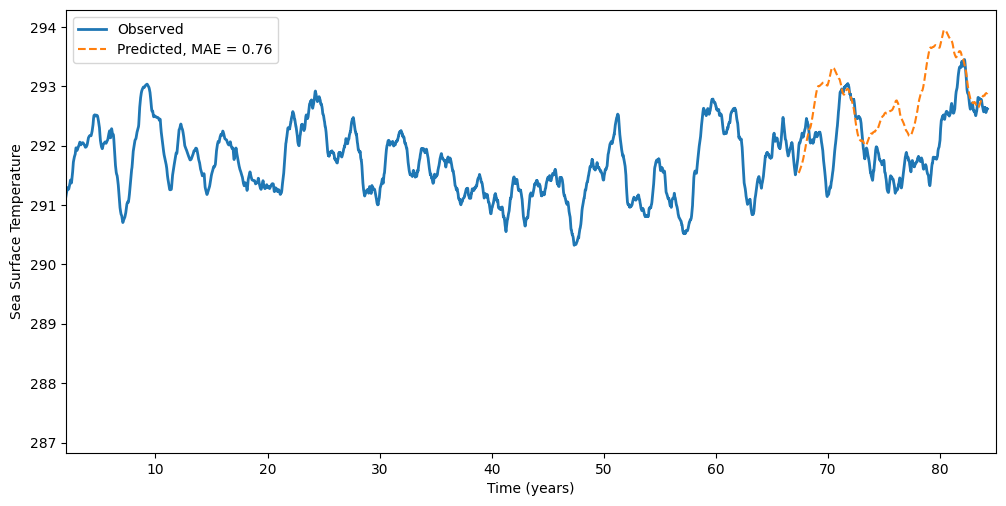

In [153]:
fig, ax = plt.subplots()
ax.plot(time/365, nsst_ma20, '-', linewidth=2, label="Observed")
ax.plot(time[test_indices]/365, forecast1.loc[test_indices, "yhat"], '--', label=f"Predicted, MAE = {mae:.2f}")
ax.legend()
ax.set_xlabel("Time (years)")
ax.set_ylabel("Sea Surface Temperature")
fig.set_size_inches(10, 5)
fig.tight_layout(pad=0.5)
plt.xlim(2,85)
plt.show()

The model used gives us an error of 0.99, and fits our model quite well by the graph below. When removing the last few years of data, we see that the predicted model fits the actual data quite well, up until the aforementioned removed data. However, the shape the data follows is good enough to project into the future.

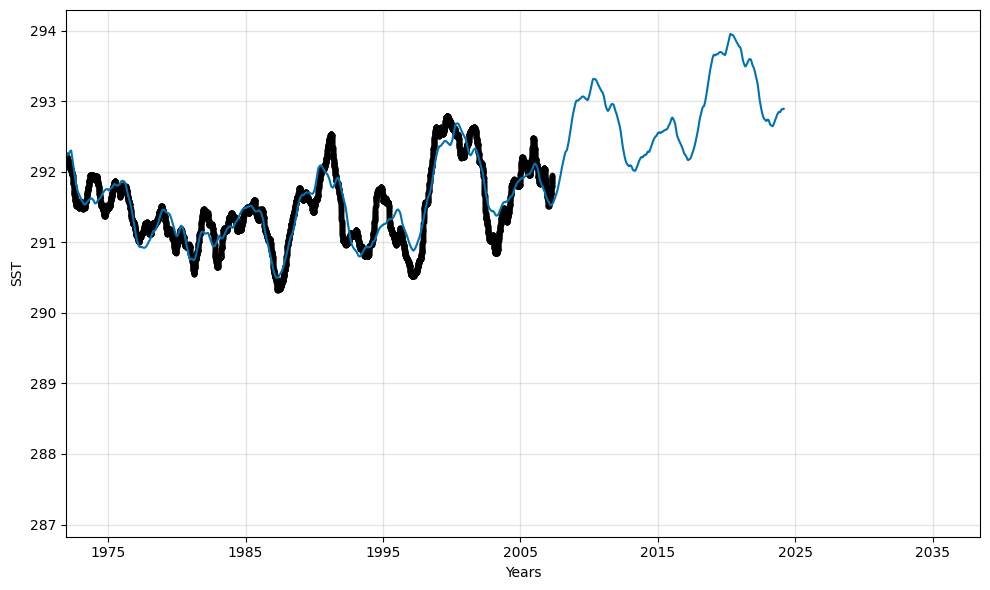

In [127]:
fig1 = m.plot(forecast1, uncertainty = False)
plt.xlim(700,25000)
plt.xlabel("Years")
plt.ylabel("SST")
ax = fig1.gca()


In [154]:
future_sst = m1.make_future_dataframe(periods=int(2 * len(nsst_test)), freq="1D")
forecast_sst = m1.predict(future_sst)

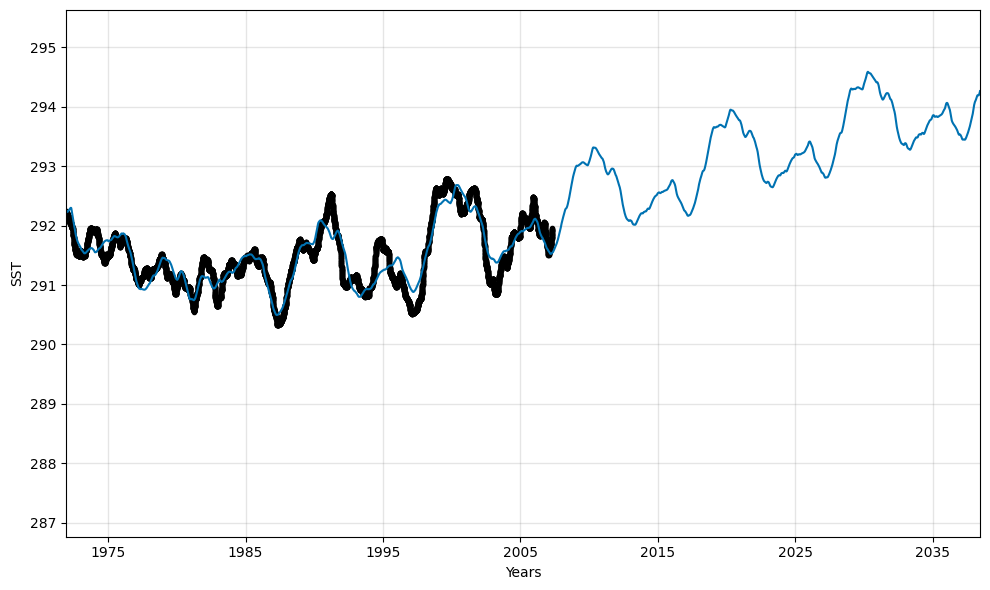

In [155]:
fig1 = m1.plot(forecast_sst, uncertainty=False)
plt.xlim(700,25000)
plt.xlabel("Years")
plt.ylabel("SST")
ax = fig1.gca()


Projecting our trend into the future, we see a clear increase in see a clear increase temperature especially based on the last few years of data. However, is our model perfect? Short answer no. The data projected shows a cyclical pattern, not just across one year, but multiple years, which isn't accurate to previous years of data.

In [130]:
spwma = df["spwma"].values.reshape(-1,1)
time = np.arange(len(df))

In [131]:
# Back to our 50/50 split
train_indices = list(range(len(df) * 4 // 5))
test_indices = list(range(len(df) * 4 // 5, len(df)))

wind_train = spwma[train_indices, :]
wind_test = spwma[test_indices, :]

df_train = pd.DataFrame({"ds": df.loc[train_indices, 'time'], "y": wind_train.squeeze()})

In [132]:
m = Prophet()

'''m.add_seasonality(name='7yr', period=365 * 7, fourier_order=10)
m.add_seasonality(name='6yr', period=365 * 6, fourier_order=10)
m.add_seasonality(name='5yr', period=365 * 5, fourier_order=10)
'''
m.add_seasonality(name="10yr", period=365 * 10, fourier_order=10)
m.add_seasonality(name="3yr", period=365 * 5, fourier_order=10)
m.add_seasonality(name='7yr', period=365 * 7, fourier_order=10)
m.add_seasonality(name='4yr', period=365 * 4, fourier_order=10)


#m.add_seasonality(name="1yr", period=365, fourier_order=10)
m.fit(df_train)
future = m.make_future_dataframe(periods=len(wind_test), freq="W")
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsadmoo6r/upx66vuj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsadmoo6r/v14k9o3b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40958', 'data', 'file=/tmp/tmpsadmoo6r/upx66vuj.json', 'init=/tmp/tmpsadmoo6r/v14k9o3b.json', 'output', 'file=/tmp/tmpsadmoo6r/prophet_modelv8apskzd/prophet_model-20240525051253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:12:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:14:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Using this model, we get a pretty accurate read on how the wind speed data will behave in the future. Testing different seasonal periodic values eventually gave me an mae of 1.052 which is good enough to project to the future.

In [133]:
mae = np.nanmean(np.abs(forecast.loc[test_indices, "yhat"] - wind_test.squeeze()))
print(mae)

1.0525629901551194


(0, 25000)

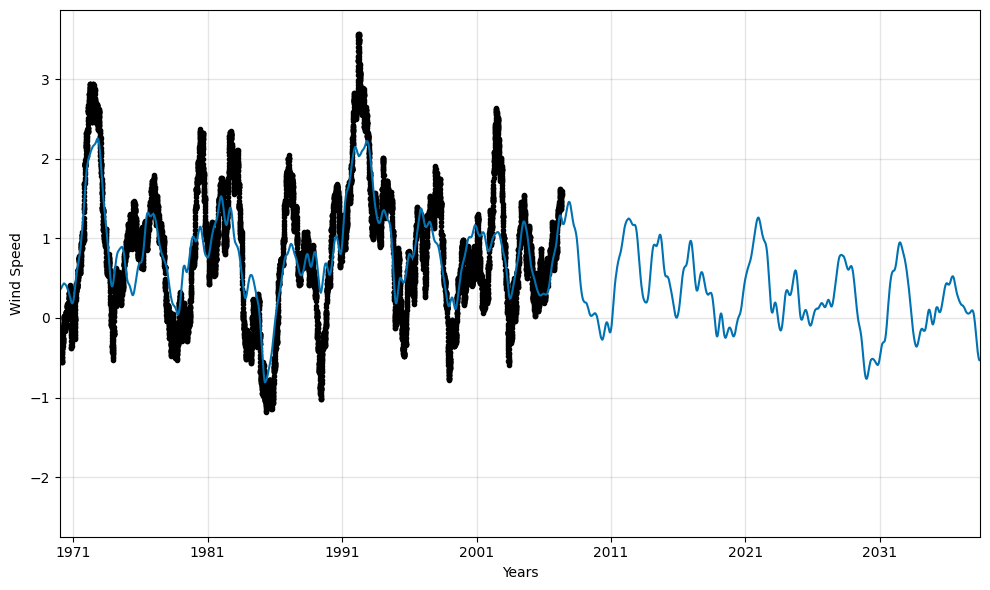

In [134]:
fig1 = m.plot(forecast, uncertainty = False)
ax = fig1.gca()
plt.xlabel("Years")
plt.ylabel("Wind Speed")
plt.xlim(0,25000)

When we look at the wind data, we can use this to predict how the El Nino/ La Nina cycles will move. We know that in the southern tropical pacific, the wind typically comes from the East, hence higher Eastern wind speed. The peaks we see are predicted to be El Nino years, and the Troughs are the La Nina years.

#Conclusion

Overall, the weather, and specifically the climate is hard to predict often due to the way nature works, however, using past data, we can predict with alright accuracy how the data might look in the future. In our sea surface temperature data, the prophet model predicts a clear upward temperature increase over time. To increase accuracy, it might be useful to use other forces such as different climate and weather patterns and do multi-variable regression to see if a more accurate model can be generated. The El Nino/ La Nina data can be improved in a similar way, because sea surface temperatrues, pressure and wind direction/ speed are all parts of how the cycles work. Also, future patterns can be predicted by using more precise locational data, such as looking at colder waters, and locations where specific climital patterns originate from.